## Import The necessary Libraries

In [1]:
#import the necessary files for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats.stats import pearsonr
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

import seaborn as sns
sns.set_style()
sns.set_context("talk")
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os 

In [3]:
current_dir = os.getcwd()

## Read The Data Files In

### Review Data

In [4]:
review_path = current_dir + '\\review_and_business_data_cleaned_withdate.csv'

In [5]:
review_data = pd.read_csv(review_path, usecols = ['user_id', 'business_id', 'stars', 'date', 'text'])

In [6]:
review_data.head()

,business_id,stars,user_id,text,date
0,oiAlXZPIFm2nBCt0DHLu_Q,3.5,IMguz1Z9dp8HG0UfeLEdEg,I've been coming to this dry cleaner for almos...,2016-06-23 05:50:54
1,oiAlXZPIFm2nBCt0DHLu_Q,3.5,_TAVpa1Y2_5KZ5wWYeX_6g,They lost 2 pairs of my suitpants and told me ...,2011-10-27 23:35:10
2,oiAlXZPIFm2nBCt0DHLu_Q,3.5,45R6BBybzwDuJaL08d1myQ,I have been going to this dry cleaning since I...,2013-07-13 03:25:04
3,oiAlXZPIFm2nBCt0DHLu_Q,3.5,lYvUtZWr1gGv4vlwNcJXDQ,The staff is very nice and friendly. However ...,2016-05-07 16:01:55
4,oiAlXZPIFm2nBCt0DHLu_Q,3.5,b0eCjnqua4C3f0OLDhZHxA,DO NOT GO HERE. They are great until there i...,2013-01-28 10:40:43


In [7]:
review_data.shape

(679950, 5)

### Business data

In [8]:
business_path = current_dir + '\\yelp_dataset\\yelp_academic_dataset_business.json'

In [9]:
business_data = pd.read_json(business_path, lines = True)

In [10]:
business_data.drop(['attributes', 'hours', 'postal_code'], axis = 1, inplace = True)

In [11]:
business_data.head()

,business_id,name,address,city,state,latitude,longitude,stars,review_count,is_open,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,35.462724,-80.852612,3.5,36,1,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,33.569404,-111.890264,5.0,4,1,"Health & Medical, Fitness & Instruction, Yoga,..."
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,45.479984,-73.580070,5.0,5,1,"Pets, Pet Services, Pet Groomers"
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,36.219728,-115.127725,2.5,3,0,"Hardware Stores, Home Services, Building Suppl..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,33.428065,-111.726648,4.5,26,1,"Home Services, Plumbing, Electricians, Handyma..."


In [12]:
business_data.shape

(209393, 11)

### User data

In [13]:
user_path = current_dir + '\\unique_user_df.csv'

In [14]:
user_data = pd.read_csv(user_path)

In [15]:
user_data = user_data[['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny', 'cool', 'elite', 'fans', 'average_stars']]

In [16]:
user_data.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,fans,average_stars
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,628,225,227,NaN,14,3.57
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,790,316,400,"2008,2009,2010,2011,2012,2013",27,3.84
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,151,125,103,2010,5,3.44
3,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,233,160,84,2009,6,3.08
4,f4_MRNHvN-yRn7EA8YWRxg,Jennifer,822,2011-01-17 00:18:23,4127,2446,2878,"2011,2012,2013,2014,2015,2016,2017,2018",137,3.63


In [17]:
user_data.shape

(285257, 10)

# Pre Processing Data

Selecting only restaurants and users from Las Vegas to limit the scope of the project. To make the test set, we hold out the last reviews of each customer by sorting by date. 

In [18]:
review_data.dropna(axis = 0, inplace = True) #Remove na values

In [19]:
review_data.shape #shape of review

(679947, 5)

In [20]:
review_data.isna().any()

business_id    False
stars          False
user_id        False
text           False
date           False
dtype: bool

In [21]:
ratings_user_date = review_data.loc[:, ['user_id', 'date']] #Selecting only user and date columns

In [22]:
ratings_user_date.date = pd.to_datetime(ratings_user_date.date) #Converting date from string 

In [23]:
#Holding out the last review for each user
index_holdout = ratings_user_date.groupby(['user_id'], sort=False)['date'].transform(max) == ratings_user_date['date']

In [25]:
#Spliting the data into train and test sets
ratings_test = review_data[index_holdout]
ratings_train = review_data[~index_holdout]

In [26]:
#Splitting train data further into validation and test sets
ratings_user_date = ratings_train.loc[:, ['user_id', 'date']]
index_holdout = ratings_user_date.groupby(['user_id'], sort=False)['date'].transform(max) == ratings_user_date['date']
ratings_val = ratings_train[index_holdout]
ratings_train = ratings_train[~index_holdout]

In [27]:
#Processing the date column to feed to model
def process(df):
    df['date']  = pd.to_datetime(df['date'])
    df['week_day'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    df['hour'] = df['date'].dt.hour
    df = df.merge(user_data, on = 'user_id')
    df = df.merge(business_data, on = 'business_id')
    rename_dict = {'business_longitude': 'longitude', 'business_latitude': 'latitude',
                  'business_state':'state','business_city':'city', 'business_address': 'address'}
    df = df.rename(columns = rename_dict)
    return df

ratings_train = process(ratings_train.copy())
ratings_holdout = process(ratings_test.copy())
ratings_val = process(ratings_val.copy())

In [28]:
#Creating full dataset using preprocessed data
ratings_train_final = ratings_train.append(ratings_val)
ratings_entire_df = ratings_train.append(ratings_val).append(ratings_holdout)

In [30]:
#Selecting rows when the rating is more than the average rating of each user
rating_above_avg = ratings_holdout[(ratings_holdout['city'] =='Las Vegas') &
                          (ratings_holdout['stars_x'] >ratings_holdout['average_stars'])]

### Baseline Prediction

Algorithm predicting the [baseline](https://surprise.readthedocs.io/en/stable/basic_algorithms.html) estimate for given user and item.

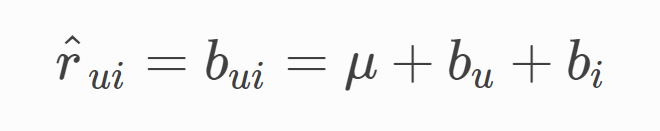

Loss: RMSE to evaluate how off the rating prediction is from the actual prediction of the user

In [32]:
from surprise import SVD
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import BaselineOnly

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [33]:
ratings_train.columns

Index(['business_id', 'stars_x', 'user_id', 'text', 'date', 'week_day',
       'month', 'hour', 'name_x', 'review_count_x', 'yelping_since', 'useful',
       'funny', 'cool', 'elite', 'fans', 'average_stars', 'name_y', 'address',
       'city', 'state', 'latitude', 'longitude', 'stars_y', 'review_count_y',
       'is_open', 'categories'],
      dtype='object')

In [34]:
trainset = ratings_train.loc[:,['user_id', 'business_id', 'stars_x']]
trainset.columns = ['userID', 'itemID','rating']
valset = ratings_val.loc[:, ['user_id', 'business_id', 'stars_x']]
valset.columns = ['userID', 'itemID','rating']
testset = ratings_holdout.loc[:, ['user_id', 'business_id', 'stars_x']]
testset.columns = ['userID', 'itemID','rating']

In [35]:
reader = Reader(rating_scale = (0.0, 5.0))
train_data = Dataset.load_from_df(trainset[['userID','itemID','rating']], reader)
val_data = Dataset.load_from_df(valset[['userID','itemID','rating']], reader)
test_data = Dataset.load_from_df(testset[['userID','itemID','rating']], reader)

train_sr = train_data.build_full_trainset()
val_sr_before = val_data.build_full_trainset()
val_sr = val_sr_before.build_testset()
test_sr_before = test_data.build_full_trainset()
test_sr = test_sr_before.build_testset()

In [36]:
bsl_options = {'method': 'als', 'n_epochs':3}
bias_baseline = BaselineOnly(bsl_options)
bias_baseline.fit(train_sr)
predictions = bias_baseline.test(val_sr)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.3979


0.3978533198914125

In [37]:

bsl_options = {'method': 'als', 'n_epochs':5}
bias_baseline = BaselineOnly(bsl_options)
bias_baseline.fit(train_sr)
predictions = bias_baseline.test(val_sr)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.3979


0.3979407532846754

In [38]:
bsl_options = {'method': 'als', 'n_epochs':9}
bias_baseline = BaselineOnly(bsl_options)
bias_baseline.fit(train_sr)
predictions = bias_baseline.test(val_sr)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.3979


0.3979468462584586

In [39]:
rmse = accuracy.rmse(predictions)
print('The rmse score of baseline model', np.round(rmse, 3))

RMSE: 0.3979
The rmse score of baseline model 0.398
